In [ ]:
import gpytorch
import torch

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [74]:
class ExactGPModel(gpytorch.models.ExactGP):
     def __init__(self, train_x, train_y, likelihood):
         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
         self.mean_module = gpytorch.means.ConstantMean()
         self.covar_module = gpytorch.kernels.ScaleKernel(
             gpytorch.kernels.RBFKernel(arg_num_dims=2)
         )

     def forward(self, x):
         mean_x = self.mean_module(x)
         covar_x = self.covar_module(x)
         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
xtrain = torch.linspace(0, 1, 10)
ytrain = torch.sin(6.28*xtrain) + 0.1*torch.randn(10,)

model = ExactGPModel(xtrain, ytrain, gpytorch.likelihoods.GaussianLikelihood())

In [4]:
def plot_mvn(x, f):
    with torch.no_grad():
        plt.plot(x, f.mean.numpy(), 'b-')
        lci, uci = f.confidence_region()
        plt.fill_between(x, lci.numpy(), uci.numpy(), alpha=0.1, color='b')
        plt.plot(xtrain, ytrain, 'k.')

In [5]:
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(torch.linspace(0,1,100))

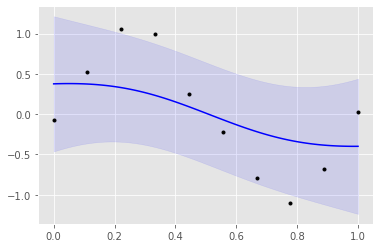

In [6]:
plot_mvn(torch.linspace(0,1,100),f)

In [7]:
model.train()
model.likelihood.train()
opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=1000)

In [8]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

In [9]:
import sys
i=0
def closure():
    global i
    output = model(xtrain)
    loss = -mll(output, ytrain)
    opt.zero_grad()
    loss.backward()
    i+=1
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
    return loss

opt.step(closure)

30

tensor(1.1439, grad_fn=<NegBackward>)

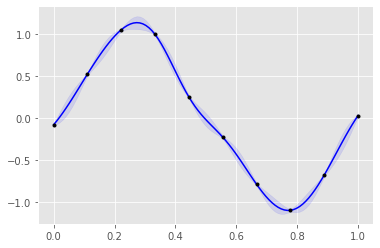

In [10]:
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(torch.linspace(0,1,100))
plot_mvn(torch.linspace(0,1,100),f)

In [11]:
model.initialize()
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-16.8821])),
             ('mean_module.constant', tensor([0.0125])),
             ('covar_module.raw_outputscale', tensor(-0.1490)),
             ('covar_module.base_kernel.raw_lengthscale',
              tensor([[-1.1991]]))])

In [12]:
model.train()
loss = -mll(model(xtrain), ytrain)

In [13]:
loss.register_hook(lambda grad: print(grad))
loss.backward()

tensor(1.)


In [14]:
model.likelihood.noise_covar.raw_noise.grad

tensor([0.])

In [75]:
xtrain = torch.meshgrid(torch.linspace(0, 1, 5), torch.linspace(0,1,5))


In [146]:
ytrain = 10*torch.sin(15.3*xtrain[0]) + 10*torch.sin(15.3*xtrain[1]) + 0.01*torch.randn(5,5)

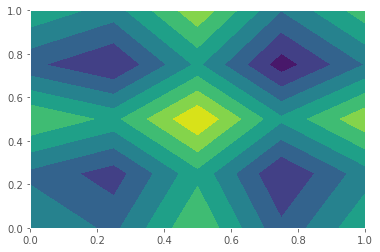

In [147]:
plt.contourf(*xtrain, ytrain)

In [148]:
_xtrain = torch.cat(
    (xtrain[0].contiguous().view(-1,1),
     xtrain[1].contiguous().view(-1,1)),
    1
)

In [149]:
_ytrain = ytrain.reshape(-1)

In [161]:
model = ExactGPModel(_xtrain, _ytrain, gpytorch.likelihoods.GaussianLikelihood())

In [162]:
model.eval()
xnew = torch.meshgrid(torch.linspace(0,1,100), torch.linspace(0,1,100))
_xnew = torch.cat(
    (xnew[0].contiguous().view(-1,1),
     xnew[1].contiguous().view(-1,1)),
    1
)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(_xnew)

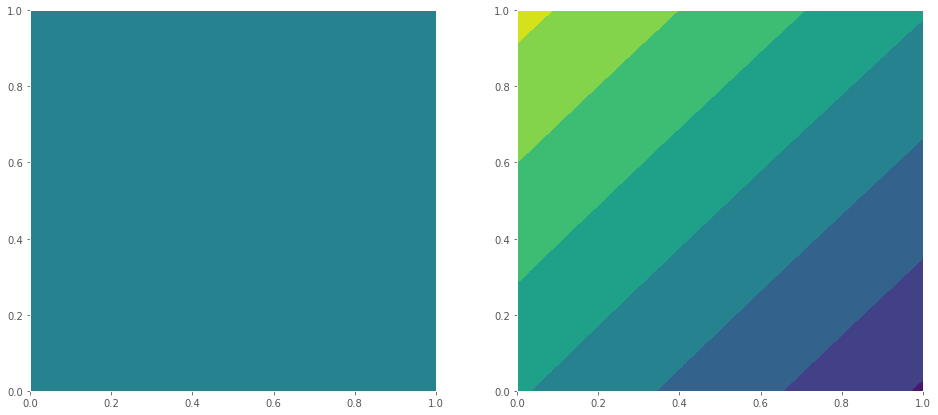

In [169]:
_,axs = plt.subplots(1,2,figsize=(16,7))
axs[0].contourf(*xnew,f.mean.reshape(100,100))
axs[1].contourf(*xnew,f.sample().reshape(100,100))

In [170]:
for name, param in model.named_parameters():
    print(name, ' ', param)

likelihood.noise_covar.raw_noise   Parameter containing:
tensor([91.9197], requires_grad=True)
mean_module.constant   Parameter containing:
tensor([-0.5718], requires_grad=True)
covar_module.raw_outputscale   Parameter containing:
tensor(-13.1025, requires_grad=True)
covar_module.base_kernel.raw_lengthscale   Parameter containing:
tensor([[11.7124]], requires_grad=True)


In [213]:
hypers = {
    'likelihood.noise_covar.noise': torch.randn((1,)).exp(),
    'covar_module.base_kernel.lengthscale': torch.randn((1,)).exp(),
    'covar_module.outputscale': torch.randn((1,)).exp()
}
model.initialize(**hypers)

print(hypers)
for name, param in model.named_parameters():
    print(name, '\n', param)

model.train()
model.likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=250)

i=0
def closure():
    global i
    opt.zero_grad()
    output = model(_xtrain)
    loss = -mll(output, _ytrain)
    loss.backward()
    i+=1
    print('%3d | loss : %8.3f' % (i, loss.item()))
#     sys.stdout.write('\r%d : loss: ' % i)
#     sys.stdout.flush()
    return loss

opt.step(closure)


for name, param in model.named_parameters():
    print(name, '\n', param)

{'likelihood.noise_covar.noise': tensor([0.7242]), 'covar_module.base_kernel.lengthscale': tensor([0.8462]), 'covar_module.outputscale': tensor([0.9253])}
likelihood.noise_covar.raw_noise 
 Parameter containing:
tensor([0.0610], requires_grad=True)
mean_module.constant 
 Parameter containing:
tensor([-0.5715], requires_grad=True)
covar_module.raw_outputscale 
 Parameter containing:
tensor(0.4204, requires_grad=True)
covar_module.base_kernel.raw_lengthscale 
 Parameter containing:
tensor([[0.2857]], requires_grad=True)
  1 | loss :   63.806
  2 | loss :   34.809
  3 | loss :   25.261
  4 | loss :   18.103
  5 | loss :   13.855
  6 | loss :   10.873
  7 | loss :    8.785
  8 | loss :    7.263
  9 | loss :    6.153
 10 | loss :    5.345
 11 | loss :    4.765
 12 | loss :    4.358
 13 | loss :    4.082
 14 | loss :    4.048
 15 | loss :    3.824
 16 | loss :    3.756
 17 | loss :    3.712
 18 | loss :    3.689
 19 | loss :    3.681
 20 | loss :    3.680
 21 | loss :    3.679
 22 | loss :  

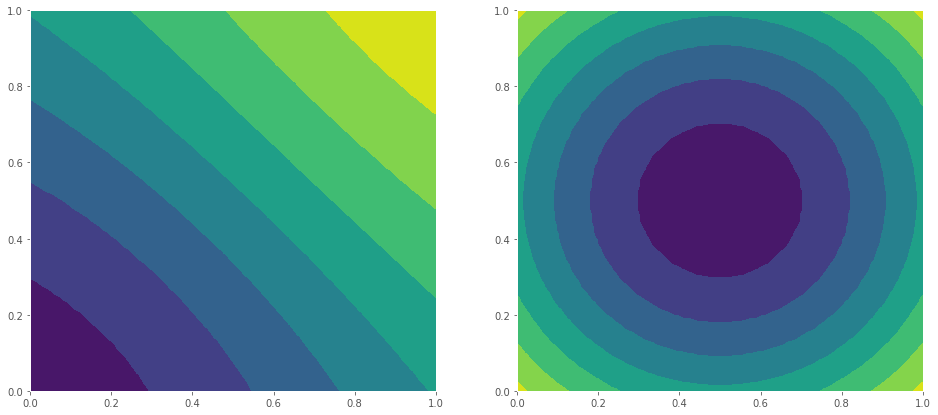

In [214]:
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(_xnew)
    
_,axs = plt.subplots(1,2,figsize=(16,7))
axs[0].contourf(*xnew,f.mean.reshape(100,100))
axs[1].contourf(*xnew,f.covariance_matrix.diag().view(100,100).detach())

In [206]:
f.mean

tensor([-0.5719, -0.5719, -0.5719,  ..., -0.5718, -0.5718, -0.5718])

In [224]:
model = ExactGPModel(_xtrain, _ytrain, gpytorch.likelihoods.GaussianLikelihood())

model.train()
model.likelihood.train()
#opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=1000)
opt = torch.optim.Adam([{'params':model.parameters()}], lr=0.05)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

min_loss = -mll(model(_xtrain), _ytrain)
eps, conv_count, N = 1e-6, 0, 99999
for i in range(N):
    opt.zero_grad()
    output = model(_xtrain)
    loss   = -mll(output, _ytrain)
    
    if (loss-min_loss).abs() < eps:
        conv_count += 1
    else:
        conv_count = 0
    
    if loss < min_loss:
        min_loss = loss
        
    if conv_count > 2:
        print('\nconverged')
        break
    
    loss.backward()
    sys.stdout.write('\riter %4d/%d - loss: %8.3f' % (i+1, N, loss.item()))
    sys.stdout.flush()
    opt.step()

iter 10217/99999 - loss:    3.680
converged


In [225]:
# likelihood.noise_covar.raw_noise 
#  Parameter containing:
# tensor([91.9259], requires_grad=True)
# mean_module.constant 
#  Parameter containing:
# tensor([-0.5718], requires_grad=True)
# covar_module.raw_outputscale 
#  Parameter containing:
# tensor(-7.5508, requires_grad=True)
# covar_module.base_kernel.raw_lengthscale 
#  Parameter containing:
# tensor([[-0.2370]], requires_grad=True)


for name, param in model.named_parameters():
    print(name, '\n', param)

likelihood.noise_covar.raw_noise 
 Parameter containing:
tensor([11.5294], requires_grad=True)
mean_module.constant 
 Parameter containing:
tensor([-0.5717], requires_grad=True)
covar_module.raw_outputscale 
 Parameter containing:
tensor(76.0048, requires_grad=True)
covar_module.base_kernel.raw_lengthscale 
 Parameter containing:
tensor([[-2.8569]], requires_grad=True)


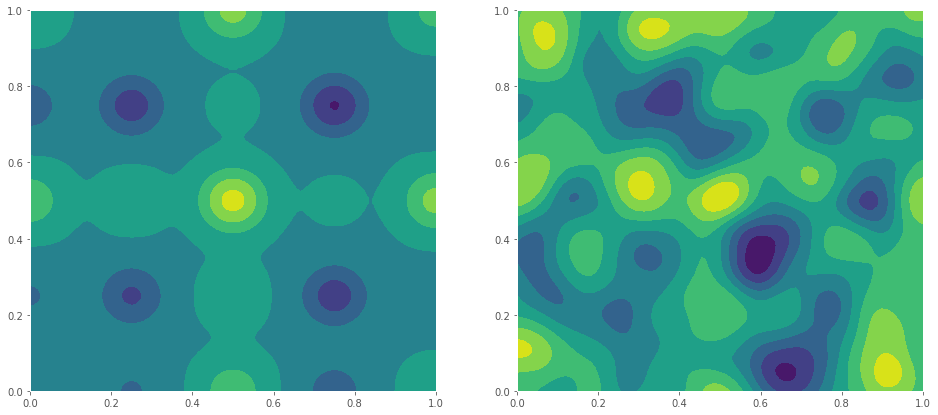

In [226]:
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(_xnew)
    
_,axs = plt.subplots(1,2,figsize=(16,7))
axs[0].contourf(*xnew,f.mean.view(100,100))
axs[1].contourf(*xnew,f.sample().view(100,100))
# axs[1].contourf(*xnew,f.covariance_matrix.diag().view(100,100).detach())

In [227]:
ytrain = 10*torch.sin(15.3*xtrain[0]) + 10*torch.sin(15.3*xtrain[1]) + 0.01*torch.randn(5,5)
ytraind1 = 153.*torch.cos(15.3*xtrain[0]) + 0.01*torch.randn(5,5)
ytraind2 = 153.*torch.cos(15.3*xtrain[1]) + 0.01*torch.randn(5,5)

In [256]:
_ytrain = torch.stack(
    [ytrain.contiguous().view(-1,1),
     ytraind1.contiguous().view(-1,1),
     ytraind2.contiguous().view(-1,1)
    ],-1).squeeze(1)

In [250]:
_ytrain.shape

torch.Size([25, 3])

In [251]:
class ExactGPModelGrad(gpytorch.models.ExactGP):
     def __init__(self, train_x, train_y, likelihood):
         super(ExactGPModelGrad, self).__init__(train_x, train_y, likelihood)
         self.mean_module = gpytorch.means.ConstantMeanGrad()
         self.covar_module = gpytorch.kernels.ScaleKernel(
             gpytorch.kernels.RBFKernelGrad(arg_num_dims=2)
         )

     def forward(self, x):
         mean_x = self.mean_module(x)
         covar_x = self.covar_module(x)
         return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [257]:
model = ExactGPModelGrad(_xtrain, _ytrain, gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3))


In [259]:

model.train()
model.likelihood.train()
#opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=1000)
opt = torch.optim.Adam([{'params':model.parameters()}], lr=0.05)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

min_loss = -mll(model(_xtrain), _ytrain)
eps, conv_count, N = 1e-3, 0, 9999
for i in range(N):
    opt.zero_grad()
    output = model(_xtrain)
    loss   = -mll(output, _ytrain)
    
    if (loss-min_loss).abs() < eps:
        conv_count += 1
    else:
        conv_count = 0
    
    if loss < min_loss:
        min_loss = loss
        
    if conv_count > 2:
        print('\nconverged')
        break
    
    loss.backward()
    sys.stdout.write('\riter %4d/%d - loss: %8.3f' % (i+1, N, loss.item()))
    sys.stdout.flush()
    opt.step()

iter 6712/9999 - loss:  135.6161
converged


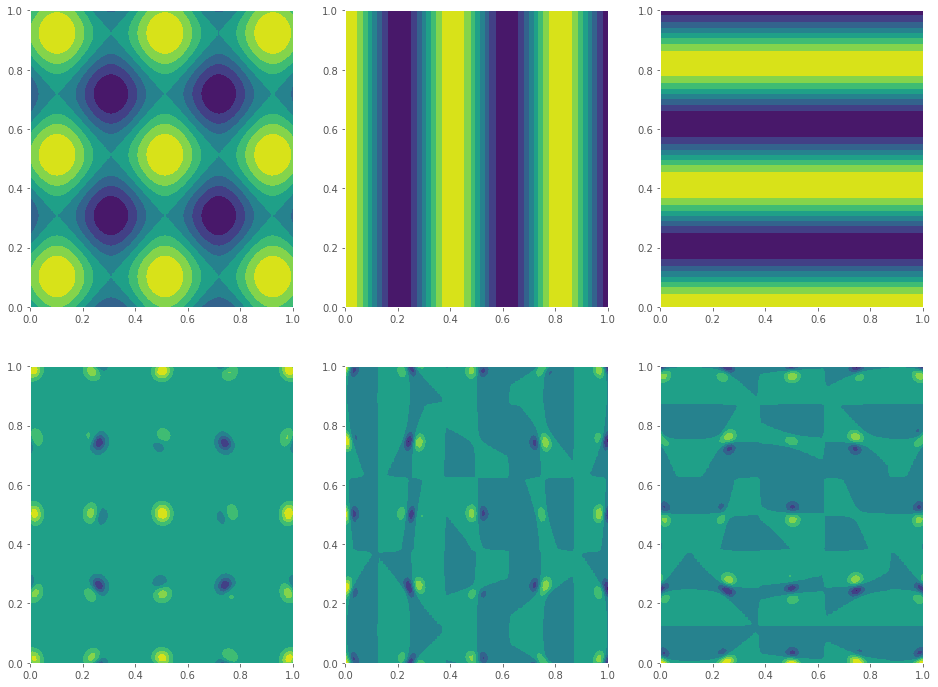

In [260]:
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(_xnew)
    
_,axs = plt.subplots(2,3,figsize=(16,12))


axs[0,0].contourf(*xnew, 10*torch.sin(15.3*xnew[0]) + 10*torch.sin(15.3*xnew[1]))
axs[0,1].contourf(*xnew, 153*torch.cos(15.3*xnew[0]))
axs[0,2].contourf(*xnew, 153*torch.cos(15.3*xnew[1]))

axs[1,0].contourf(*xnew,f.mean[:,0].view(100,100))
axs[1,1].contourf(*xnew,f.mean[:,1].view(100,100))
axs[1,2].contourf(*xnew,f.mean[:,2].view(100,100))
# axs[1].contourf(*xnew,f.covariance_matrix.diag().view(100,100).detach())

In [280]:
model

ExactGPModelGrad(
  (likelihood): MultitaskGaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): MultitaskHomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (mean_module): ConstantMeanGrad()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernelGrad(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [282]:
model = ExactGPModelGrad(_xtrain, _ytrain, gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3))

rand_hp = lambda sc: torch.nn.functional.softplus(sc*torch.randn((1,)))

model.covar_module.outputscale = rand_hp(10.)
model.covar_module.base_kernel.lengthscale = rand_hp(10.)

model.train()
model.likelihood.train()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=250)

i=0
def closure():
    global i
    opt.zero_grad()
    output = model(_xtrain)
    loss = -mll(output, _ytrain)
    loss.backward()
    #i+=1
    #print('%3d | loss : %8.3f' % (i, loss.item()))
#     sys.stdout.write('\r%d : loss: ' % i)
#     sys.stdout.flush()
    return loss

num_retries = 5
min_loss = 
for j in range(num_retries):
    #i=0
    
    model = ExactGPModelGrad(_xtrain, _ytrain, gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3))

    rand_hp = lambda sc: torch.nn.functional.softplus(sc*torch.randn((1,)))

    model.covar_module.outputscale = rand_hp(10.)
    model.covar_module.base_kernel.lengthscale = rand_hp(10.)

    model.train()
    model.likelihood.train()

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    opt = torch.optim.LBFGS([{'params':model.parameters()}], max_iter=250)
    
    opt.step(closure)

    loss = -mll(model(_xtrain), _ytrain)
    min_loss = 
    print('try %d | loss %8.3f (min.=%8.3f)')
    

  1 | loss : 8415.262
  2 | loss : 1409.628
  3 | loss : 1120.195
  4 | loss :  661.398
  5 | loss :  540.037
  6 | loss :  384.634
  7 | loss :  226.800
  8 | loss :  212.557
  9 | loss :  197.066
 10 | loss :  186.764
 11 | loss :  175.128
 12 | loss :  162.472
 13 | loss :  149.742
 14 | loss :  145.198
 15 | loss :  140.138
 16 | loss :  137.529
 17 | loss :  135.531
 18 | loss :  134.379
 19 | loss :  133.709
 20 | loss :  133.261
 21 | loss :  133.064
 22 | loss :  132.985
 23 | loss :  132.962
 24 | loss :  132.958
 25 | loss :  132.955
 26 | loss :  132.954
 27 | loss :  132.954
 28 | loss :  132.954



In [284]:
opt

LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 1
    max_eval: 312
    max_iter: 250
    tolerance_change: 1e-09
    tolerance_grad: 1e-07
)

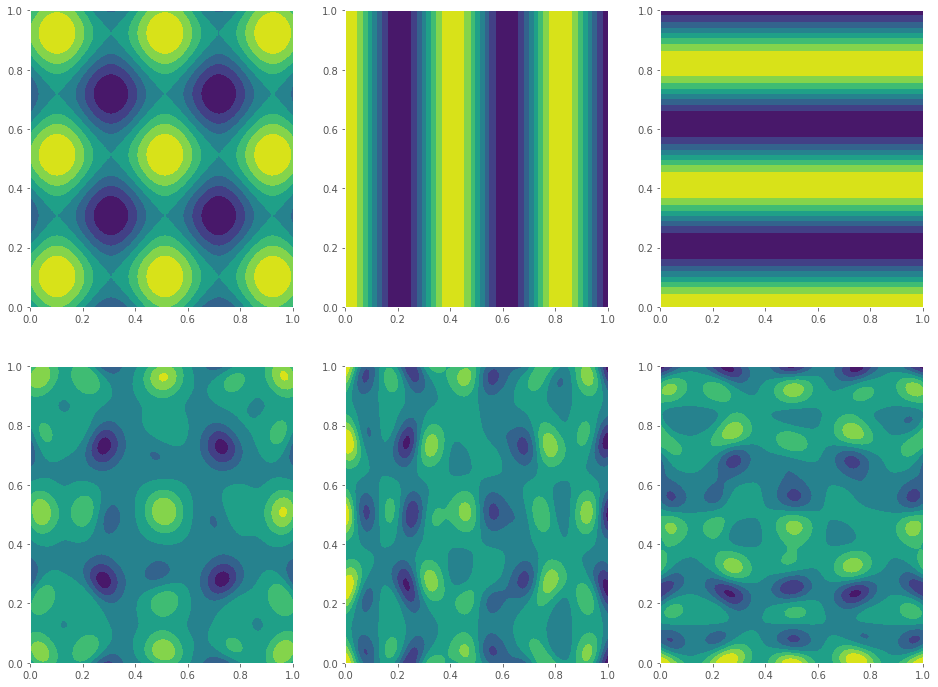

In [283]:
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f = model(_xnew)
    
_,axs = plt.subplots(2,3,figsize=(16,12))


axs[0,0].contourf(*xnew, 10*torch.sin(15.3*xnew[0]) + 10*torch.sin(15.3*xnew[1]))
axs[0,1].contourf(*xnew, 153*torch.cos(15.3*xnew[0]))
axs[0,2].contourf(*xnew, 153*torch.cos(15.3*xnew[1]))

axs[1,0].contourf(*xnew,f.mean[:,0].view(100,100))
axs[1,1].contourf(*xnew,f.mean[:,1].view(100,100))
axs[1,2].contourf(*xnew,f.mean[:,2].view(100,100))
# axs[1].contourf(*xnew,f.covariance_matrix.diag().view(100,100).detach())